In [1]:
#pip install yahoofinancials # if package is not installed, please uncomment to install
#pip install numpy_financial

import pandas as pd
import numpy as np
import scipy.stats as st
import datetime
from dateutil.relativedelta import *
import matplotlib.pylab as plt
from yahoofinancials import YahooFinancials
import numpy_financial as npf


In [ ]:
report_date = '2021-06-01'

In [2]:
# select asset, time period, frequancy 

# run this for USD Portfolio
assets = ['SPY','QQQ','VWO','EWC','EFA','VGK','IOO','SHY','IEF','TIP','IYR','DBC']
inqu = ['^IRX','CADUSD=X']+assets
yahoo_financials = YahooFinancials(inqu)
data = yahoo_financials.get_historical_price_data(start_date='2006-04-01', 
                                                  end_date='2021-06-02', 
                                                  time_interval='monthly')

In [3]:
# run this for CAD Portfolio

assets = ['XSP.TO','XIU.TO','XIN.TO','XBB.TO','XGB.TO','XRB.TO','XRE.TO']
inqu = ['^IRX','CADUSD=X']+assets
yahoo_financials = YahooFinancials(inqu)
data = yahoo_financials.get_historical_price_data(start_date='2006-04-01', 
                                                  end_date='2021-06-02', 
                                                  time_interval='monthly')
                                                  

In [4]:
# format risk free rate
df_rf = pd.DataFrame(data['^IRX']['prices'])
df_rf = df_rf.drop('date', axis=1).set_index('formatted_date')
df_rf['Mth_rf'] = df_rf['adjclose']/100/12
df_rf = df_rf.fillna(method='ffill')

# format exchange rate
'''
# somehow the date messed up, we will read the excel file instead
df_ex = pd.DataFrame(data['CADUSD=X']['prices'])
df_ex = df_ex.set_index('formatted_date')
df_ex = df_ex.fillna(method='ffill')
df_ex['CAD/USD'] = df_ex['adjclose'] 
df_ex.drop(columns= ['date','high','low','open','close','volume','adjclose'], inplace=True)
'''

# somehow the date messed up, we will read the csv file instead
df_ex = pd.read_csv('CADUSD=X.csv')
df_ex = df_ex.set_index('Date')
df_ex = df_ex.fillna(method='ffill')
df_ex['CAD/USD'] = df_ex['Adj Close'] 
df_ex.drop(columns= ['Open','High','Low','Close','Adj Close','Volume'], inplace=True)

# format asset returns
df=pd.DataFrame(index=df_rf.index)

for asset in assets:
    df[asset+'_P']=pd.DataFrame(data[asset]['prices'])[['adjclose','formatted_date']].set_index('formatted_date')
    df[asset+'_R']=df[asset+'_P'].pct_change(1)

In [5]:
df

,XSP.TO_P,XSP.TO_R,XIU.TO_P,XIU.TO_R,XIN.TO_P,XIN.TO_R,XBB.TO_P,XBB.TO_R,XGB.TO_P,XGB.TO_R,XRB.TO_P,XRB.TO_R,XRE.TO_P,XRE.TO_R
formatted_date,,,,,,,,,,,,,,
2006-04-01,13.145290,NaN,11.521857,NaN,17.995522,NaN,16.917009,NaN,NaN,NaN,14.437650,NaN,6.142775,NaN
2006-05-01,12.707119,-0.033333,11.153104,-0.032005,16.989994,-0.055877,16.982298,0.003859,NaN,NaN,14.296542,-0.009774,6.151716,0.001456
2006-06-01,12.794751,0.006896,11.037451,-0.010370,17.191097,0.011837,16.697371,-0.016778,NaN,NaN,14.051461,-0.017143,6.120422,-0.005087
2006-07-01,12.810687,0.001246,11.291711,0.023036,17.232704,0.002420,17.248827,0.033027,NaN,NaN,14.674636,0.044349,6.482049,0.059085
2006-08-01,13.081561,0.021144,11.542490,0.022209,17.718132,0.028169,17.561024,0.018100,NaN,NaN,14.960310,0.019467,6.672697,0.029412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-01,40.849056,0.027277,26.603354,0.036510,27.332333,0.027902,31.725668,-0.027332,22.031994,-0.031403,25.542923,-0.042799,16.469028,0.038749
2021-03-01,42.650196,0.044093,28.012825,0.052981,28.717251,0.050670,31.317741,-0.012858,21.713200,-0.014470,25.324438,-0.008554,17.255177,0.047735
2021-04-01,44.809574,0.050630,28.658510,0.023050,29.033804,0.011023,31.326403,0.000277,21.741892,0.001321,24.817949,-0.020000,18.062016,0.046759


In [6]:
# equal weighted method
def EW(df):
    weights = [1/7,1/7,1/7,1/7,1/7,1/7,1/7]
    return weights

In [70]:
# calibration period back function 
def back_mth(str_date, month_back):
    t=datetime.datetime.strptime(str_date, "%Y-%m-%d").date()
    t=t+ relativedelta(months=-month_back)
    t=t.strftime('%Y-%m-%d')
    return t

In [8]:
# construct inception and rebalance date

# validation period
incept_date_v = '2011-04-01'
rebal_dates_v = pd.date_range(start=incept_date_v, periods=21, freq='2QS')[1:] #['2011-10-01', '2012-04-01', ... ,'2021-04-01']

# testing period
incept_date_t = '2016-04-01'
rebal_dates_t = pd.date_range(start=incept_date_t, periods=11, freq='2QS')[1:] #['2016-10-01', '2017-04-01', ... ,'2021-04-01']

In [9]:
# managing data

# Portfolio price and return
df['Port_P'] = np.NaN
df['Port_R'] = np.NaN


# dataframes for asset's return, excess return, price, weight, and unit of shares 
df_R = pd.DataFrame(index=df.index)
df_exR = pd.DataFrame(index=df.index)
df_P = pd.DataFrame(index=df.index)
df_W = pd.DataFrame(index=df.index)
df_U = pd.DataFrame(index=df.index)

for asset in assets:
    df_R[asset]=df[asset+'_R']
    df_exR[asset]=df[asset+'_R']-df_rf['Mth_rf']
    df_P[asset]=df[asset+'_P']
    df_W[asset]=np.NaN
    df_U[asset]=np.NaN
    
# dataframes for transaction records and fee
df_trans_rec = pd.DataFrame(columns=assets)
df_trans_fee = pd.DataFrame(columns=assets)    
    
# dataframes for annual return for fiscal year
df_RR = pd.DataFrame(columns=['TWRR']+assets)
report_dates = pd.date_range(start=incept_date_v, periods=11, freq='4QS')[1:].strftime('%Y-%m-%d').to_list()+[report_date]

In [139]:
df_exR

,XSP.TO,XIU.TO,XIN.TO,XBB.TO,XGB.TO,XRB.TO,XRE.TO
formatted_date,,,,,,,
2006-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-05-01,-0.037262,-0.035934,-0.059806,-0.000070,NaN,-0.013703,-0.002474
2006-06-01,0.002846,-0.014420,0.007787,-0.020828,NaN,-0.021193,-0.009137
2006-07-01,-0.002867,0.018924,-0.001692,0.028914,NaN,0.040237,0.054973
2006-08-01,0.017057,0.018122,0.024081,0.014012,NaN,0.015380,0.025324
...,...,...,...,...,...,...,...
2021-02-01,0.027248,0.036481,0.027873,-0.027362,-0.031432,-0.042828,0.038720
2021-03-01,0.044082,0.052970,0.050659,-0.012869,-0.014480,-0.008564,0.047724
2021-04-01,0.050627,0.023047,0.011021,0.000274,0.001319,-0.020003,0.046757


In [133]:
# Try each strategy

# choose validation or testing mode v<->t
inc_date = incept_date_t
rb_dates = rebal_dates_t

# initial Portfolio value
inc_value=100000/2#*df_ex.loc[inc_date,'CAD/USD'] # if needed to convert to USD
df.loc[inc_date,'Port_P'] = inc_value

# injection value (in cad)
inject_value = 10000/2

# calibration period (max 59 for this example)
Back = 59

# Transaction fee rate
fee_rate = 0.005

# initial asset weights
'''pick strategy function'''
weights = EW(df_exR.loc[:inc_date,:])
dict_weights = dict(zip(assets, weights))

# initial unit of shares to invest
for asset in assets:
    df_W.loc[inc_date,asset] = dict_weights[asset]
    df_U.loc[inc_date,asset] = dict_weights[asset]*inc_value/df_P.loc[inc_date,asset]
    df_trans_rec.loc[inc_date,asset] = df_U.loc[inc_date,asset]

# Portfolio evaluation
for i in df.index:
    if i > inc_date:
        
        df_U.loc[i]= df_U.shift().loc[i]
        df.loc[i,'Port_P'] = df_U.loc[i].dot(df_P.loc[i])
        df.loc[i,'Port_R'] = df.loc[i,'Port_P']/df.shift().loc[i,'Port_P']-1
        df_W.loc[i] = df_U.loc[i]*df_P.loc[i]/df.loc[i,'Port_P']

        if i in rb_dates:
            
            # new asset weights
            '''pick strategy fuction'''
            weights = EW(df_exR.loc[back_mth(i, Back):i,:])
            dict_weights = dict(zip(assets, weights))

            # total transaction cost at rebalance date
            trans_cost = 0
            
            # injection if needed
            new_port = df.loc[i,'Port_P']+inject_value#*df_ex.loc[i,'CAD/USD'] # if need to convert to USD
            
            for asset in assets:
                df_W.loc[i,asset] = dict_weights[asset]
                new_unit = dict_weights[asset]*new_port/df_P.loc[i,asset]
                old_unit = df_U.loc[i,asset]
                df_trans_rec.loc[i,asset] = new_unit - old_unit
                df_trans_fee.loc[i,asset] = abs(new_unit - old_unit)*df_P.loc[i,asset]*fee_rate
                trans_cost = trans_cost + df_trans_fee.loc[i,asset]
                
            df.loc[i,'Port_P'] = new_port-trans_cost
                        
            # new unit of shares
            for asset in assets:
                df_U.loc[i,asset] = dict_weights[asset]*df.loc[i,'Port_P']/df_P.loc[i,asset]
                
        # record fiscal year end annual return        
        if i in report_dates:
            
            df_RR.loc[i,['TWRR']] = ((df.loc[back_mth(report_dates[report_dates.index(i)-1],-1):i,['Port_R']]+1).prod()-1)[0]
            
            for asset in assets:
                df_RR.loc[i,[asset]] = ((df_R.loc[back_mth(report_dates[report_dates.index(i)-1],-1):i,[asset]]+1).prod()-1)[0]
            
    

In [11]:
df.to_excel("cad_EW_t.xlsx")

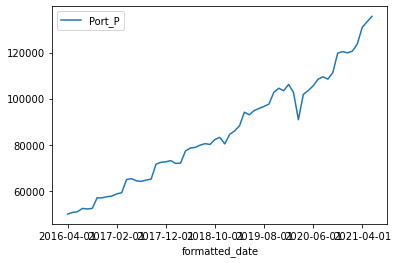

In [46]:
df.loc[inc_date:,['Port_P']].plot()

In [13]:
df

,XSP.TO_P,XSP.TO_R,XIU.TO_P,XIU.TO_R,XIN.TO_P,XIN.TO_R,XBB.TO_P,XBB.TO_R,XGB.TO_P,XGB.TO_R,XRB.TO_P,XRB.TO_R,XRE.TO_P,XRE.TO_R,Port_P,Port_R
formatted_date,,,,,,,,,,,,,,,,
2006-04-01,13.145290,NaN,11.521857,NaN,17.995522,NaN,16.917009,NaN,NaN,NaN,14.437650,NaN,6.142775,NaN,NaN,NaN
2006-05-01,12.707119,-0.033333,11.153104,-0.032005,16.989994,-0.055877,16.982298,0.003859,NaN,NaN,14.296542,-0.009774,6.151716,0.001456,NaN,NaN
2006-06-01,12.794751,0.006896,11.037451,-0.010370,17.191097,0.011837,16.697371,-0.016778,NaN,NaN,14.051461,-0.017143,6.120422,-0.005087,NaN,NaN
2006-07-01,12.810687,0.001246,11.291711,0.023036,17.232704,0.002420,17.248827,0.033027,NaN,NaN,14.674636,0.044349,6.482049,0.059085,NaN,NaN
2006-08-01,13.081561,0.021144,11.542490,0.022209,17.718132,0.028169,17.561024,0.018100,NaN,NaN,14.960310,0.019467,6.672697,0.029412,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-01,40.849056,0.027277,26.603354,0.036510,27.332333,0.027902,31.725668,-0.027332,22.031994,-0.031403,25.542923,-0.042799,16.469028,0.038749,120630.995336,0.006222
2021-03-01,42.650196,0.044093,28.012825,0.052981,28.717251,0.050670,31.317741,-0.012858,21.713200,-0.014470,25.324438,-0.008554,17.255177,0.047735,123727.171566,0.025667
2021-04-01,44.809574,0.050630,28.658510,0.023050,29.033804,0.011023,31.326403,0.000277,21.741892,0.001321,24.817949,-0.020000,18.062016,0.046759,130937.071944,0.018547


In [120]:
port_now=df.loc[report_date,'Port_P']

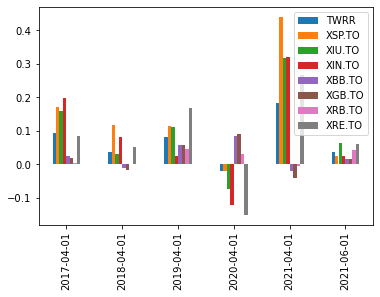

In [136]:
df_RR.plot.bar()

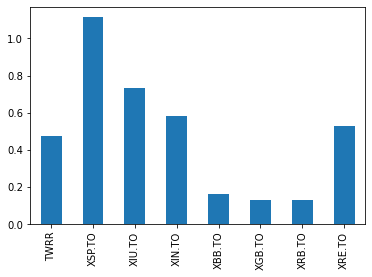

In [138]:
((df_RR+1).prod()-1).plot.bar() 

In [40]:
# calculate sharpe of each asset
stats=pd.DataFrame()
stats["mean"]=df_R.loc[back_mth(inc_date,-1):,:].mean()
stats["std"]=df_R.loc[back_mth(inc_date,-1):,:].std()
stats['annual mean']=stats["mean"]*12
stats['annual std']=stats["std"]*np.sqrt(12)
stats['sharpe'] = stats['annual mean']/stats['annual std']
stats

,mean,std,annual mean,annual std,sharpe
XSP.TO,0.013101,0.043820,0.157210,0.151796,1.035670
XIU.TO,0.009567,0.036640,0.114804,0.126924,0.904510
XIN.TO,0.008178,0.038789,0.098138,0.134368,0.730371
XBB.TO,0.002518,0.013835,0.030213,0.047924,0.630427
XGB.TO,0.002078,0.012963,0.024931,0.044903,0.555222
XRB.TO,0.002197,0.022604,0.026362,0.078301,0.336681
XRE.TO,0.008172,0.049279,0.098066,0.170709,0.574462


In [41]:
# calculate sharpe of portfolio
stats=pd.DataFrame()
stats["mean"]=df.loc[back_mth(inc_date,-1):,['Port_R']].mean()
stats["std"]=df.loc[back_mth(inc_date,-1):,['Port_R']].std()
stats['annual mean']=stats["mean"]*12
stats['annual std']=stats["std"]*np.sqrt(12)
stats['sharpe'] = stats['annual mean']/stats['annual std']
stats

,mean,std,annual mean,annual std,sharpe
Port_R,0.006599,0.024732,0.079192,0.085674,0.924345


In [16]:
# risk management

In [18]:
position_now = df_U.loc[report_date]*df_P.loc[report_date]
position_now

XSP.TO    19183.001913
XIU.TO    19926.810408
XIN.TO    19157.791855
XBB.TO    19019.147310
XGB.TO    19036.634851
XRB.TO    19536.144890
XRE.TO    19845.869518
Name: 2021-06-01, dtype: float64

In [19]:
position_now.sum()

135705.40074448736

In [20]:
# VaR (hist method) of each asset
df_R.quantile([.01])

,XSP.TO,XIU.TO,XIN.TO,XBB.TO,XGB.TO,XRB.TO,XRE.TO
0.01,-0.113811,-0.133683,-0.118551,-0.027895,-0.027628,-0.078873,-0.124519


In [21]:
df_R.quantile([.01])*(position_now)

,XSP.TO,XIU.TO,XIN.TO,XBB.TO,XGB.TO,XRB.TO,XRE.TO
0.01,-2183.243262,-2663.878162,-2271.167,-530.537391,-525.948217,-1540.87456,-2471.197548


In [22]:
# VaR (hist method) of portfolio
df.loc[:,'Port_R'].sort_values()

formatted_date
2020-03-01   -0.115447
2018-10-01   -0.035181
2018-12-01   -0.033980
2020-02-01   -0.032362
2020-10-01   -0.020224
                ...   
2015-12-01         NaN
2016-01-01         NaN
2016-02-01         NaN
2016-03-01         NaN
2016-04-01         NaN
Name: Port_R, Length: 183, dtype: float64

In [23]:
df[['Port_R']].quantile([.01])

,Port_R
0.01,-0.066485


In [24]:
port_now*df['Port_R'].quantile([.01])

0.01   -9022.339545
Name: Port_R, dtype: float64

In [ ]:
# VaR (parametric method) of each asset

In [25]:
VaRi_p = df_R.mean()+st.norm.ppf(.01)*df_R.std()
VaRi_p

XSP.TO   -0.096821
XIU.TO   -0.084201
XIN.TO   -0.097575
XBB.TO   -0.025489
XGB.TO   -0.025609
XRB.TO   -0.055120
XRE.TO   -0.098998
dtype: float64

In [26]:
VaRi_p*position_now

XSP.TO   -1857.326126
XIU.TO   -1677.859237
XIN.TO   -1869.319812
XBB.TO    -484.771683
XGB.TO    -487.500539
XRB.TO   -1076.823010
XRE.TO   -1964.705806
dtype: float64

In [27]:
# VaR (parametric method) of portfolio

In [28]:
VaRp_p = df['Port_R'].mean()+st.norm.ppf(.01)*df['Port_R'].std()
VaRp_p

-0.050935514894079374

In [29]:
VaRp_p*port_now

-6912.224460827846

In [30]:
# Marginal VaR

In [31]:
df_W.loc[report_date]

XSP.TO    0.141358
XIU.TO    0.146839
XIN.TO    0.141172
XBB.TO    0.140150
XGB.TO    0.140279
XRB.TO    0.143960
XRE.TO    0.146242
Name: 2021-06-01, dtype: float64

In [32]:
df_R.cov()

,XSP.TO,XIU.TO,XIN.TO,XBB.TO,XGB.TO,XRB.TO,XRE.TO
XSP.TO,0.002028,0.001407,0.001760,0.000034,-0.000045,0.000254,0.001224
XIU.TO,0.001407,0.001508,0.001320,0.000060,-0.000026,0.000312,0.001161
XIN.TO,0.001760,0.001320,0.001896,0.000028,-0.000043,0.000232,0.001165
XBB.TO,0.000034,0.000060,0.000028,0.000156,0.000144,0.000220,0.000211
XGB.TO,-0.000045,-0.000026,-0.000043,0.000144,0.000153,0.000202,0.000119
XRB.TO,0.000254,0.000312,0.000232,0.000220,0.000202,0.000636,0.000465
XRE.TO,0.001224,0.001161,0.001165,0.000211,0.000119,0.000465,0.002090


In [33]:
df_R.cov().dot(df_W.loc[report_date])

XSP.TO    0.000956
XIU.TO    0.000826
XIN.TO    0.000912
XBB.TO    0.000122
XGB.TO    0.000072
XRB.TO    0.000333
XRE.TO    0.000927
dtype: float64

In [34]:
df_W.loc[report_date].dot(df_R.cov().dot(df_W.loc[report_date]))

0.0005958863653908229

In [35]:
MVaR=(df_R.cov().dot(df_W.loc[report_date]))/(df_W.loc[report_date].dot(df_R.cov().dot(df_W.loc[report_date])))*df_W.loc[report_date]
MVaR

XSP.TO    0.226737
XIU.TO    0.203606
XIN.TO    0.216044
XBB.TO    0.028737
XGB.TO    0.016923
XRB.TO    0.080490
XRE.TO    0.227463
dtype: float64

In [36]:
MVaR*VaRp_p

XSP.TO   -0.011549
XIU.TO   -0.010371
XIN.TO   -0.011004
XBB.TO   -0.001464
XGB.TO   -0.000862
XRB.TO   -0.004100
XRE.TO   -0.011586
dtype: float64

In [37]:
MVaR*VaRp_p*port_now

XSP.TO   -1567.253960
XIU.TO   -1407.372175
XIN.TO   -1493.346224
XBB.TO    -198.637095
XGB.TO    -116.974855
XRB.TO    -556.365991
XRE.TO   -1572.274160
dtype: float64

In [38]:
sum(MVaR*VaRp_p*port_now)

-6912.224460827847